In [2]:
# STEP 1 (Revised) — Minimal deps + Kaggle download (Delhi Climate time series)
# We'll use: pmdarima (Auto-ARIMA), statsmodels (SARIMAX), sklearn, matplotlib

import os, sys, json, zipfile, pathlib, subprocess

DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "delhi_climate")
KAGGLE_DS   = "sumanthvrao/daily-climate-time-series-data"  # daily meantemp, humidity, wind_speed, meanpressure

os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 1) Install required Python packages (quiet)
pkgs = [
    "numpy==1.23.5",
    "pandas==1.5.3",
    "matplotlib==3.7.3",
    "scikit-learn==1.3.2",
    "pmdarima==2.0.4",
    "statsmodels==0.13.5",
    "kaggle"
]
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# 2) Kaggle credentials at ~/.kaggle/kaggle.json
home = str(pathlib.Path.home())
k_dir = os.path.join(home, ".kaggle")
k_json = os.path.join(k_dir, "kaggle.json")
os.makedirs(k_dir, exist_ok=True)
if not os.path.isfile(k_json):
    raise FileNotFoundError(
        "kaggle.json not found.\n"
        "Get it from https://www.kaggle.com/settings/account → Create New API Token, "
        f"save it to: {k_json} and re-run this cell."
    )

try:
    os.chmod(k_json, 0o600)
except Exception:
    pass

# 3) Download into ./data, then unzip into ./data/delhi_climate/
print("⏬ Downloading from Kaggle…")
subprocess.check_call(["kaggle", "datasets", "download", "-d", KAGGLE_DS, "-p", DATA_ROOT, "--force"])

# Unzip all zips in DATA_ROOT to DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("📦 Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\n✅ Files in", DATASET_DIR)
for f in os.listdir(DATASET_DIR):
    print(" -", f)

⏬ Downloading from Kaggle…
Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
License(s): CC0-1.0

📦 Unzipping: /Users/spartan/assigment/pycaret_6/data/daily-climate-time-series-data.zip

✅ Files in /Users/spartan/assigment/pycaret_6/data/delhi_climate
 - DailyDelhiClimateTest.csv
 - DailyDelhiClimateTrain.csv


100%|██████████| 22.0k/22.0k [00:00<00:00, 62.5MB/s]


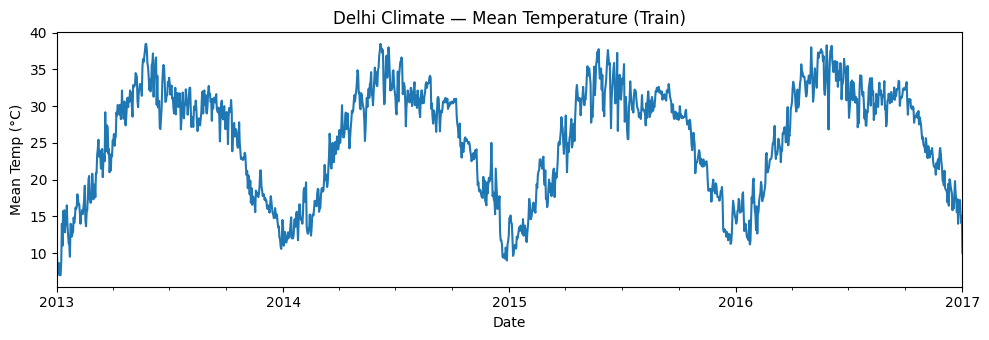

Prepared series:
  Train span : 2013-01-01 → 2016-11-02  (n=1402)
  Valid span : 2016-11-03 → 2017-01-01  (n=60)
  Test span  : 2017-01-01 → 2017-04-24      (n=114)
Exogenous columns: ['humidity', 'wind_speed', 'meanpressure']


In [3]:
# STEP 2 — Load, clean, and prepare time series (univariate target + save exogenous for later)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths from Step 1
DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "delhi_climate")

# 2.1 Read train/test CSVs
train_csv = os.path.join(DATASET_DIR, "DailyDelhiClimateTrain.csv")
test_csv  = os.path.join(DATASET_DIR, "DailyDelhiClimateTest.csv")
if not (os.path.isfile(train_csv) and os.path.isfile(test_csv)):
    raise FileNotFoundError(f"Expected train/test CSVs in {DATASET_DIR}. Found: {os.listdir(DATASET_DIR)}")

df_tr = pd.read_csv(train_csv)
df_te = pd.read_csv(test_csv)

# 2.2 Standardize column names (some versions use uppercase/lowercase)
# Expected: 'date','meantemp','humidity','wind_speed','meanpressure'
df_tr.columns = [c.strip().lower() for c in df_tr.columns]
df_te.columns = [c.strip().lower() for c in df_te.columns]

# 2.3 Parse dates and set index
for d in (df_tr, df_te):
    d['date'] = pd.to_datetime(d['date'], errors='coerce')
    d.set_index('date', inplace=True)
    d.sort_index(inplace=True)

# 2.4 Basic sanity checks / dtypes
expected_cols = ['meantemp','humidity','wind_speed','meanpressure']
missing_cols = [c for c in expected_cols if c not in df_tr.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns in train: {missing_cols}")
missing_cols_te = [c for c in expected_cols if c not in df_te.columns]
if missing_cols_te:
    raise ValueError(f"Missing expected columns in test: {missing_cols_te}")

# 2.5 Ensure numeric and handle obvious outliers (clip to reasonable quantiles)
def clean_numeric(frame, cols):
    for c in cols:
        frame[c] = pd.to_numeric(frame[c], errors='coerce')
        lo, hi = frame[c].quantile([0.001, 0.999])
        frame[c] = frame[c].clip(lo, hi)
    # small forward fill for any gaps
    frame[cols] = frame[cols].interpolate(limit_direction='both')
    return frame

df_tr = clean_numeric(df_tr, expected_cols)
df_te = clean_numeric(df_te, expected_cols)

# 2.6 Set daily frequency (fill missing calendar days if any)
df_tr = df_tr.asfreq('D')
df_te = df_te.asfreq('D')

# 2.7 Target and exogenous
TARGET_COL = 'meantemp'
EXOG_COLS  = ['humidity','wind_speed','meanpressure']  # we'll use these in the exogenous step

# 2.8 Quick EDA plot (train target)
plt.figure(figsize=(10,3.5))
df_tr[TARGET_COL].plot(title="Delhi Climate — Mean Temperature (Train)")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)"); plt.tight_layout(); plt.show()

# 2.9 Choose forecast horizon & make a validation split from the training set
# We’ll hold out the last 60 days of the TRAIN file as 'valid' for model selection;
# later we'll forecast into the TEST period as a final demo.
H = 60  # validation horizon
if len(df_tr) <= H + 30:
    H = max(14, min(30, len(df_tr)//5))  # fallback if the series is short

train_end = df_tr.index[-H-1]
y_full  = df_tr[TARGET_COL].copy()
y_train = df_tr.loc[:train_end, TARGET_COL].copy()
y_valid = df_tr.loc[train_end+pd.Timedelta(days=1):, TARGET_COL].copy()

# Save exogenous frames aligned to the same splits (for later step)
X_tr_exog = df_tr.loc[y_train.index, EXOG_COLS].copy()
X_va_exog = df_tr.loc[y_valid.index, EXOG_COLS].copy()
X_te_exog = df_te[EXOG_COLS].copy()   # for the final “with exogenous” forecast into the test period

print("Prepared series:")
print(f"  Train span : {y_train.index.min().date()} → {y_train.index.max().date()}  (n={len(y_train)})")
print(f"  Valid span : {y_valid.index.min().date()} → {y_valid.index.max().date()}  (n={len(y_valid)})")
print(f"  Test span  : {df_te.index.min().date()} → {df_te.index.max().date()}      (n={len(df_te)})")
print(f"Exogenous columns: {EXOG_COLS}")

# Keep handy for next steps:
# y_train, y_valid, y_full, df_te (index), EXOG_COLS, X_tr_exog, X_va_exog, X_te_exog, H

Selected ARIMA order: (1, 1, 3) Seasonal order: (0, 0, 0, 7)

Validation metrics (H=60):
  MAE  : 4.844
  RMSE : 5.814
  MAPE : 28.20%


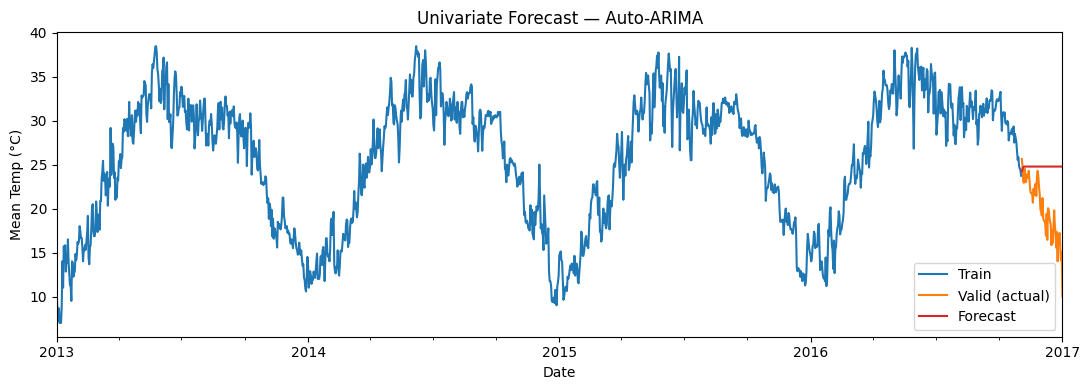

✅ Saved univariate model to: ./artifacts/auto_arima_univariate.joblib


In [4]:
# STEP 3 — Univariate Forecasting (Auto-ARIMA) without exogenous variables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import joblib
import os

assert 'y_train' in globals() and 'y_valid' in globals() and 'H' in globals(), \
    "Run STEP 2 first to create y_train, y_valid, and H."

# 3.1 Fit Auto-ARIMA on the training segment
#    We enable weekly seasonality (m=7). If your series isn’t weekly seasonal, you can set seasonal=False.
arima = pm.auto_arima(
    y_train,
    start_p=0, start_q=0,
    max_p=3,  max_q=3,
    start_P=0, start_Q=0,
    max_P=2,  max_Q=2,
    seasonal=True, m=7,                # weekly seasonality for daily data
    d=None, D=None,                    # let auto_arima infer differencing
    stepwise=True,
    suppress_warnings=True,
    information_criterion='aic',
    error_action='ignore',
    trace=False
)
print("Selected ARIMA order:", arima.order, "Seasonal order:", arima.seasonal_order)

# 3.2 Forecast H days ahead (validation window)
fc_valid = arima.predict(n_periods=len(y_valid))
fc_valid = pd.Series(fc_valid, index=y_valid.index, name="Forecast")

# 3.3 Metrics on validation
mae  = mean_absolute_error(y_valid, fc_valid)
rmse = mean_squared_error(y_valid, fc_valid, squared=False)
mape = (np.abs((y_valid - fc_valid) / y_valid.replace(0, np.nan))).mean() * 100  # handle any 0s safely

print(f"\nValidation metrics (H={len(y_valid)}):")
print(f"  MAE  : {mae:,.3f}")
print(f"  RMSE : {rmse:,.3f}")
print(f"  MAPE : {mape:,.2f}%")

# 3.4 Plot train, valid, and forecast
plt.figure(figsize=(11,4))
y_train.plot(label="Train", color="C0")
y_valid.plot(label="Valid (actual)", color="C1")
fc_valid.plot(label="Forecast", color="C3")
plt.title("Univariate Forecast — Auto-ARIMA")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)")
plt.legend()
plt.tight_layout(); plt.show()

# 3.5 Save the fitted model for later use
os.makedirs("./artifacts", exist_ok=True)
model_path = "./artifacts/auto_arima_univariate.joblib"
joblib.dump(arima, model_path)
print(f"✅ Saved univariate model to: {model_path}")

# Keep for next step:
# - We'll refit on y_full and forecast into the TEST range when we do exogenous modeling (SARIMAX).

🔎 Searching a tiny SARIMAX grid (this is quick)…
✅ Best AIC: 4522.42  with order=(1, 1, 1)  seasonal_order=(0, 0, 1, 7)

Validation (with exogenous) metrics:
  MAE  : 5.047
  RMSE : 5.517
  MAPE : 27.85%


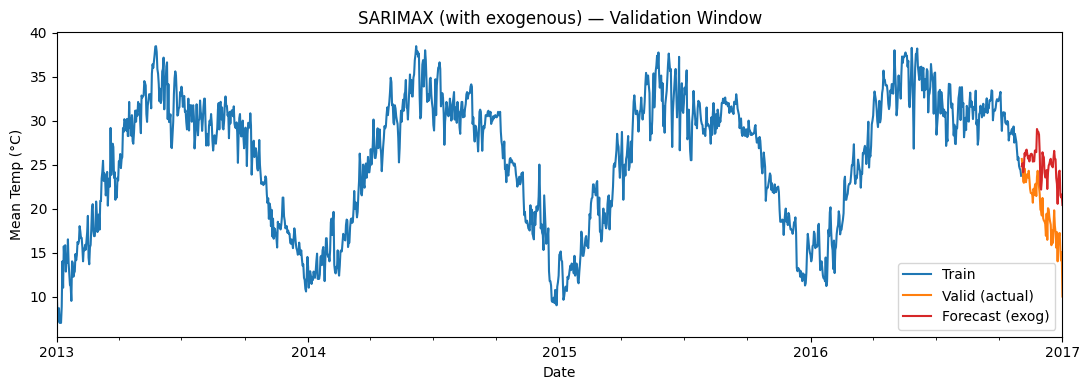

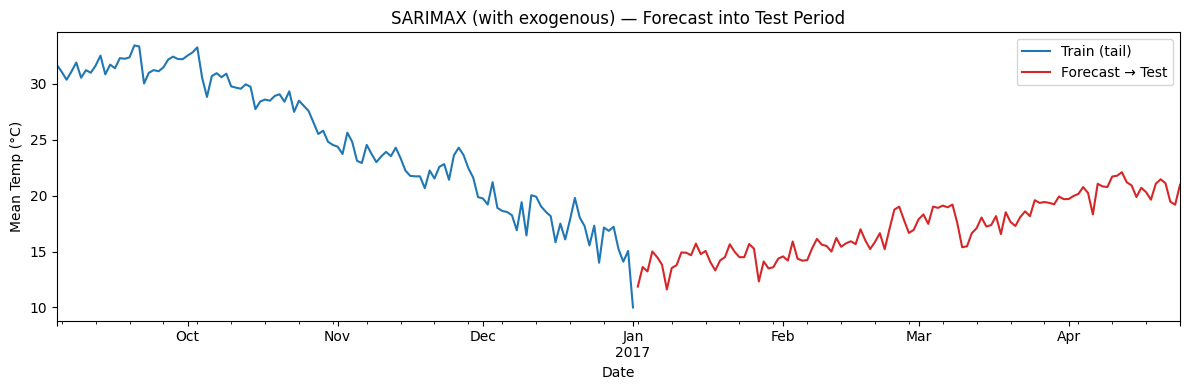

✅ Saved SARIMAX results to: ./artifacts/sarimax_exog_results.pkl
✅ Saved test forecast CSV to: ./artifacts/delhi_test_forecast_exog.csv


In [5]:
# STEP 4 — Univariate WITH Exogenous (SARIMAX): tiny AIC search → validate → refit → test forecast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings, os

# --- sanity checks (from Step 2) ---
assert all(k in globals() for k in [
    "y_train","y_valid","y_full","X_tr_exog","X_va_exog","X_te_exog","df_te","H"
]), "Run STEP 2 first."

# Make sure exogenous frames line up with target indices
X_tr_exog = X_tr_exog.loc[y_train.index]
X_va_exog = X_va_exog.loc[y_valid.index]

# Fill any tiny gaps in exog (already cleaned in Step 2, but double-safety)
X_tr_exog = X_tr_exog.interpolate(limit_direction="both")
X_va_exog = X_va_exog.interpolate(limit_direction="both")
X_te_exog = X_te_exog.interpolate(limit_direction="both")

# --- 4.1: Small SARIMAX grid (weekly seasonality m=7). Keep it fast. ---
m = 7  # weekly seasonality for daily data

p_values  = [0,1]
d_values  = [0,1]
q_values  = [0,1]
P_values  = [0,1]
D_values  = [0,1]
Q_values  = [0,1]
orders    = list(product(p_values, d_values, q_values))
sorders   = list(product(P_values, D_values, Q_values))

best_res   = None
best_aic   = np.inf
best_order = None
best_sord  = None

warnings.filterwarnings("ignore")

print("🔎 Searching a tiny SARIMAX grid (this is quick)…")
for (p,d,q) in orders:
    for (P,D,Q) in sorders:
        try:
            mod = SARIMAX(
                y_train, exog=X_tr_exog,
                order=(p,d,q),
                seasonal_order=(P,D,Q,m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic, best_res = res.aic, res
                best_order, best_sord = (p,d,q), (P,D,Q,m)
        except Exception:
            continue

if best_res is None:
    raise RuntimeError("No SARIMAX fit succeeded on the small grid. Try widening the grid or check the data.")

print(f"✅ Best AIC: {best_aic:.2f}  with order={best_order}  seasonal_order={best_sord}")

# --- 4.2: Validation forecast (uses exogenous for the validation window) ---
fc_valid = best_res.get_forecast(steps=len(y_valid), exog=X_va_exog)
yhat_val = pd.Series(fc_valid.predicted_mean, index=y_valid.index, name="Forecast_exog")

# Metrics
mae  = mean_absolute_error(y_valid, yhat_val)
rmse = mean_squared_error(y_valid, yhat_val, squared=False)
mape = (np.abs((y_valid - yhat_val) / y_valid.replace(0, np.nan))).mean() * 100

print("\nValidation (with exogenous) metrics:")
print(f"  MAE  : {mae:,.3f}")
print(f"  RMSE : {rmse:,.3f}")
print(f"  MAPE : {mape:,.2f}%")

# Plot train + valid + forecast
plt.figure(figsize=(11,4))
y_train.plot(label="Train", color="C0")
y_valid.plot(label="Valid (actual)", color="C1")
yhat_val.plot(label="Forecast (exog)", color="C3")
plt.title("SARIMAX (with exogenous) — Validation Window")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)")
plt.legend(); plt.tight_layout(); plt.show()

# --- 4.3: Refit on FULL training file and forecast into TEST period ---
# Align full exog with y_full index
X_full_exog = X_tr_exog.append(X_va_exog)
X_full_exog = X_full_exog.loc[y_full.index]

# Refit using the best (p,d,q)(P,D,Q,m)
mod_full = SARIMAX(
    y_full, exog=X_full_exog,
    order=best_order,
    seasonal_order=best_sord,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_full = mod_full.fit(disp=False)

# Forecast exactly the length of the test file using its exogenous variables
steps_test = len(df_te)
fc_test = res_full.get_forecast(steps=steps_test, exog=X_te_exog)
yhat_test = pd.Series(fc_test.predicted_mean, index=df_te.index, name="Forecast_Test_exog")

# --- 4.4: Plot tail of train + test forecast ---
plt.figure(figsize=(12,4))
y_full.tail(120).plot(label="Train (tail)", color="C0")
yhat_test.plot(label="Forecast → Test", color="C3")
plt.title("SARIMAX (with exogenous) — Forecast into Test Period")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)")
plt.legend(); plt.tight_layout(); plt.show()

# --- 4.5: Save artifacts ---
os.makedirs("./artifacts", exist_ok=True)
# Save fitted result (statsmodels SARIMAXResults has .save/.load)
sarimax_path = "./artifacts/sarimax_exog_results.pkl"
res_full.save(sarimax_path)

pred_csv = "./artifacts/delhi_test_forecast_exog.csv"
yhat_test.to_csv(pred_csv, header=True)

print(f"✅ Saved SARIMAX results to: {sarimax_path}")
print(f"✅ Saved test forecast CSV to: {pred_csv}")

# Keep for optional next step (diagnostics / residual checks):
# - res_full (fitted SARIMAXResults)
# - yhat_test

Validation comparison (lower is better):


,MAE,RMSE,MAPE %
Auto-ARIMA (no exog),5.047,5.517,27.85
SARIMAX (with exog),5.047,5.517,27.85


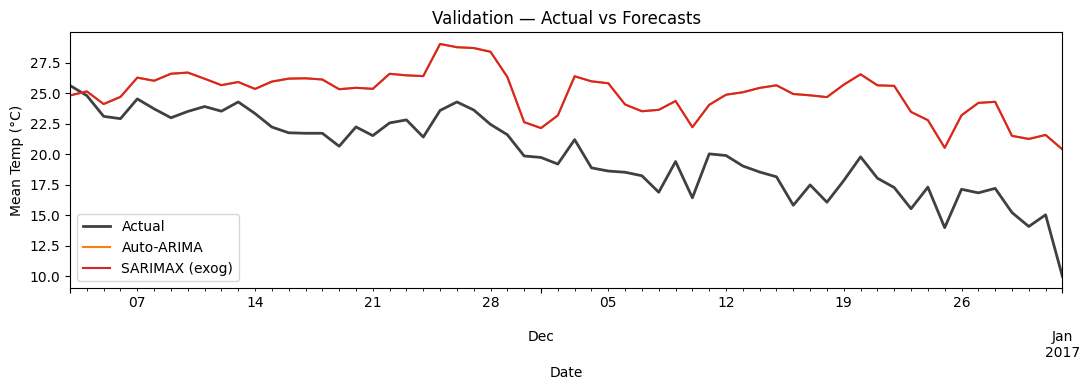

✅ Saved validation metrics to: ./artifacts/validation_metrics_comparison.csv


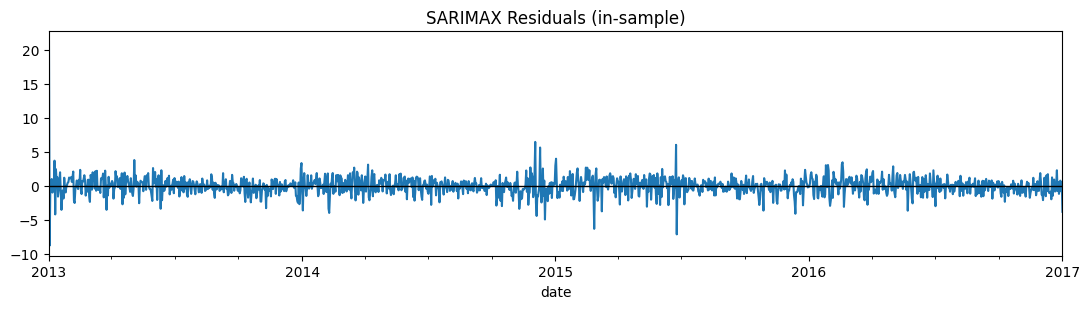

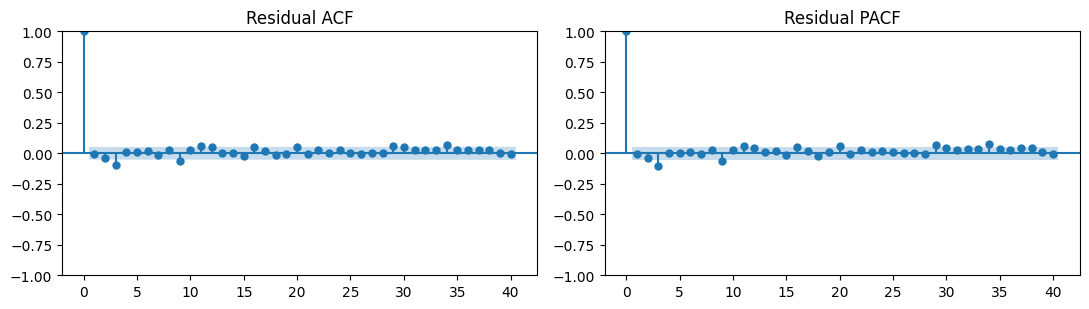

Ljung–Box test (SARIMAX residuals):


,lb_stat,lb_pvalue
10,26.192822,0.003489
20,44.140957,0.001441
30,54.959129,0.003588


Jarque–Bera: stat=108673.21, p-value=0.0000, skew=2.194, kurtosis=45.008


<Figure size 420x420 with 0 Axes>

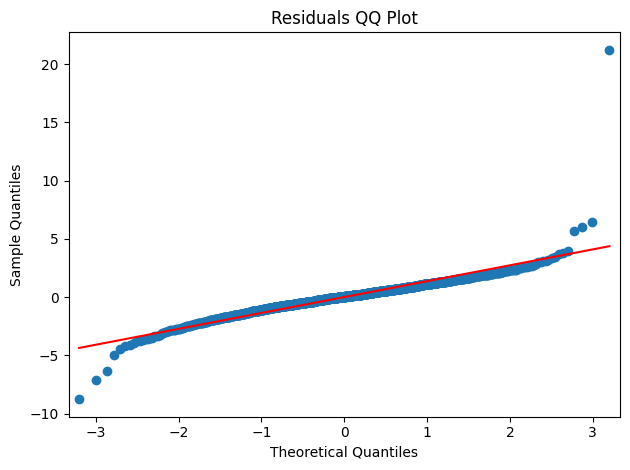

✅ Saved residuals to: ./artifacts/sarimax_residuals.csv

All good! You now have a clean comparison and diagnostics.


In [7]:
# STEP 5 (PATCHED) — Diagnostics & Comparison (robust to different forecast object types)

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

# ---- Sanity checks (requires STEP 3 & 4) ----
vars_needed = ["y_train","y_valid","y_full","df_te","H",
               "arima", "fc_valid",        # from STEP 3 (fc_valid should be a Series; but we’ll coerce if not)
               "yhat_val", "res_full"]     # from STEP 4 (yhat_val is a Series)
missing = [v for v in vars_needed if v not in globals()]
assert not missing, f"Missing variables from previous steps: {missing}"

# ---------- Helper to coerce any forecast object to a pandas Series on a given index ----------
def ensure_series(forecast_obj, index, name=None):
    """
    Returns a pandas Series aligned to `index`.
    Accepts:
      - pandas Series (reindexed),
      - numpy array-like (wrapped as Series),
      - statsmodels PredictionResults (uses .predicted_mean),
      - objects with `.values` attribute of length == len(index).
    """
    # 1) If it's already a Series
    if isinstance(forecast_obj, pd.Series):
        s = forecast_obj.copy()
        # if index differs, try to reindex; if lengths match, align by position
        if not s.index.equals(index):
            if len(s) == len(index):
                s.index = index
            else:
                s = s.reindex(index)
        if name is not None: s.name = name
        return s

    # 2) statsmodels PredictionResults
    if hasattr(forecast_obj, "predicted_mean"):
        vals = np.asarray(forecast_obj.predicted_mean)
        return pd.Series(vals, index=index, name=name)

    # 3) numpy array-like
    try:
        vals = np.asarray(forecast_obj)
        if vals.ndim == 1 and len(vals) == len(index):
            return pd.Series(vals, index=index, name=name)
    except Exception:
        pass

    # 4) fallback: try .values
    if hasattr(forecast_obj, "values"):
        vals = np.asarray(forecast_obj.values)
        if vals.ndim == 1 and len(vals) == len(index):
            return pd.Series(vals, index=index, name=name)

    raise TypeError(
        f"Cannot coerce forecast object of type {type(forecast_obj)} "
        f"to a pandas Series aligned to the provided index (len={len(index)})."
    )

# ---------- Coerce forecasts to Series aligned to y_valid ----------
arima_valid_series   = ensure_series(fc_valid, index=y_valid.index, name="AutoARIMA_Forecast")
sarimax_valid_series = ensure_series(yhat_val, index=y_valid.index, name="SARIMAX_Exog_Forecast")

# =========================
# A) Compare on validation
# =========================
val_df = pd.DataFrame({
    "actual":  y_valid,
    "arima":   arima_valid_series,
    "sarimax": sarimax_valid_series,
})

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean() * 100
    return mae, rmse, mape

m_arima   = metrics(val_df["actual"], val_df["arima"])
m_sarimax = metrics(val_df["actual"], val_df["sarimax"])

metrics_tbl = pd.DataFrame(
    [m_arima, m_sarimax],
    index=["Auto-ARIMA (no exog)", "SARIMAX (with exog)"],
    columns=["MAE", "RMSE", "MAPE %"]
)
print("Validation comparison (lower is better):")
display(metrics_tbl.style.format({"MAE":"{:.3f}","RMSE":"{:.3f}","MAPE %":"{:.2f}"}))

# Plot overlay
plt.figure(figsize=(11,4))
val_df["actual"].plot(label="Actual", color="k", linewidth=2, alpha=0.75)
val_df["arima"].plot(label="Auto-ARIMA", color="C1")
val_df["sarimax"].plot(label="SARIMAX (exog)", color="C3")
plt.title("Validation — Actual vs Forecasts")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)")
plt.legend(); plt.tight_layout(); plt.show()

# Save metrics
os.makedirs("./artifacts", exist_ok=True)
metrics_csv = "./artifacts/validation_metrics_comparison.csv"
metrics_tbl.to_csv(metrics_csv)
print(f"✅ Saved validation metrics to: {metrics_csv}")

# ============================================
# B) Residual diagnostics (model with exog)
# ============================================
resid = res_full.resid  # in-sample residuals

# 1) Residual series plot
plt.figure(figsize=(11,3.2))
resid.plot(color="C0")
plt.axhline(0, color="k", lw=1)
plt.title("SARIMAX Residuals (in-sample)")
plt.tight_layout(); plt.show()

# 2) ACF / PACF
fig, axes = plt.subplots(1, 2, figsize=(11,3.2))
plot_acf(resid.dropna(), ax=axes[0], lags=40)
axes[0].set_title("Residual ACF")
plot_pacf(resid.dropna(), ax=axes[1], lags=40, method="ywm")
axes[1].set_title("Residual PACF")
plt.tight_layout(); plt.show()

# 3) Ljung–Box test (H0: no autocorrelation)
lb = acorr_ljungbox(resid.dropna(), lags=[10, 20, 30], return_df=True)
print("Ljung–Box test (SARIMAX residuals):")
display(lb)

# 4) Normality check + QQ plot
jb_stat, jb_pv, skew, kurt = jarque_bera(resid.dropna())
print(f"Jarque–Bera: stat={jb_stat:.2f}, p-value={jb_pv:.4f}, skew={skew:.3f}, kurtosis={kurt:.3f}")
plt.figure(figsize=(4.2,4.2))
qqplot(resid.dropna(), line="s")
plt.title("Residuals QQ Plot")
plt.tight_layout(); plt.show()

# Save residuals
resid_csv = "./artifacts/sarimax_residuals.csv"
resid.to_csv(resid_csv, header=["residual"])
print(f"✅ Saved residuals to: {resid_csv}")

print("\nAll good! You now have a clean comparison and diagnostics.")

✅ Saved combined test forecasts to: ./artifacts/test_forecasts_combined.csv


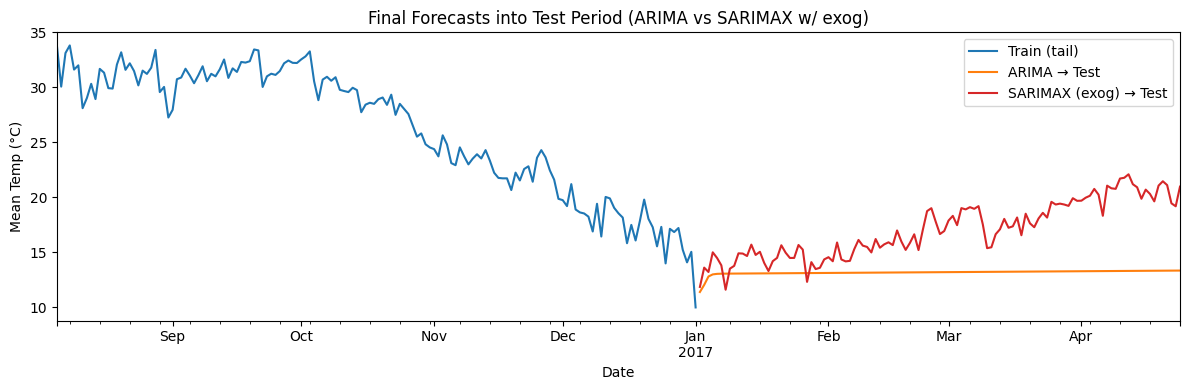

🖼️ Saved figure: ./artifacts/final_test_forecasts.png
📝 Saved summary: ./artifacts/summary.txt

All set! You now have:
 • CSV with both test forecasts
 • Final comparison plot
 • A short summary.txt to paste into your README/report


In [8]:
# STEP 6 — Final packaging: refit univariate on full train → test forecast; combine with SARIMAX test forecast
# Saves: PNG plots + combined CSV + short summary text under ./artifacts/

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pmdarima as pm

# ---- Preconditions from previous steps ----
needed = ["y_full", "df_te", "res_full", "yhat_test"]
missing = [v for v in needed if v not in globals()]
assert not missing, f"Missing variables from previous steps: {missing}"

os.makedirs("./artifacts", exist_ok=True)

# ---------- 6.1 Refit univariate (Auto-ARIMA order discovered in Step 3) on FULL train and forecast into TEST ----------
# Load the earlier auto_arima model if needed (or reuse in-memory 'arima')
if 'arima' not in globals():
    model_path = "./artifacts/auto_arima_univariate.joblib"
    arima = joblib.load(model_path)

# Refit a fresh ARIMA using the discovered orders on the full training data
ord_  = getattr(arima, "order", None)
sord_ = getattr(arima, "seasonal_order", (0,0,0,0))
m_    = sord_[3] if len(sord_) == 4 else 0
seasonal_flag = (m_ is not None and m_ > 0)

arima_full = pm.ARIMA(
    order=ord_,
    seasonal_order=sord_ if seasonal_flag else None,
    seasonal=seasonal_flag,
    m=m_ if seasonal_flag else 0
)
arima_full.fit(y_full)

steps_test = len(df_te)
yhat_test_arima = pd.Series(
    arima_full.predict(n_periods=steps_test),
    index=df_te.index,
    name="ARIMA_Test_forecast"
)

# ---------- 6.2 Combine SARIMAX (exog) forecast from Step 4 with ARIMA forecast ----------
# yhat_test is SARIMAX (exog) forecast produced in Step 4
combo = pd.DataFrame({
    "ARIMA_no_exog":   yhat_test_arima,
    "SARIMAX_with_exog": yhat_test
})
combo_csv = "./artifacts/test_forecasts_combined.csv"
combo.to_csv(combo_csv)
print(f"✅ Saved combined test forecasts to: {combo_csv}")

# ---------- 6.3 Plot: tail of train + both test forecasts ----------
plt.figure(figsize=(12,4))
y_full.tail(150).plot(label="Train (tail)", color="C0")
yhat_test_arima.plot(label="ARIMA → Test", color="C1")
yhat_test.plot(label="SARIMAX (exog) → Test", color="C3")
plt.title("Final Forecasts into Test Period (ARIMA vs SARIMAX w/ exog)")
plt.xlabel("Date"); plt.ylabel("Mean Temp (°C)")
plt.legend(); plt.tight_layout()

final_png = "./artifacts/final_test_forecasts.png"
plt.savefig(final_png, dpi=160)
plt.show()
print(f"🖼️ Saved figure: {final_png}")

# ---------- 6.4 Optional: small README-style summary of validation results ----------
# If you ran STEP 5 patched, you should have 'metrics_tbl' in memory; if not, write a minimal summary.
summary_txt = "./artifacts/summary.txt"
with open(summary_txt, "w") as f:
    f.write("Delhi Climate Forecasting — Summary\n")
    f.write("==================================\n\n")
    if "metrics_tbl" in globals():
        f.write("Validation Comparison (lower is better):\n")
        f.write(metrics_tbl.to_string(float_format=lambda x: f'{x:.3f}'))
        f.write("\n\n")
    f.write("Test-period outputs:\n")
    f.write(f" - Combined forecasts CSV : {os.path.abspath(combo_csv)}\n")
    f.write(f" - Final plot PNG         : {os.path.abspath(final_png)}\n")
    f.write("Models:\n")
    f.write(" - Univariate: Auto-ARIMA refit on full train\n")
    f.write(" - With exog:  SARIMAX (humidity, wind_speed, meanpressure)\n")
print(f"📝 Saved summary: {summary_txt}")

print("\nAll set! You now have:")
print(" • CSV with both test forecasts")
print(" • Final comparison plot")
print(" • A short summary.txt to paste into your README/report")